In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model

import os

from PIL import Image

random_state = 112221

## EDA

In [16]:
train_labels = pd.read_csv('data/trainLabels.csv')
train_labels

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


In [17]:
train_labels['image'] = train_labels['image'] + '.jpeg'

In [18]:
train_labels

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1
...,...,...
35121,44347_right.jpeg,0
35122,44348_left.jpeg,0
35123,44348_right.jpeg,0
35124,44349_left.jpeg,0


In [19]:
train_labels['level'].value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

In [20]:
#Binary Classification
train_labels['level'].replace([1,2,3,4], 1, inplace = True)
train_labels['level'] = train_labels['level'].astype('str')

In [21]:
train_labels['level'].value_counts()

0    25810
1     9316
Name: level, dtype: int64

In [22]:
train_labels

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1
...,...,...
35121,44347_right.jpeg,0
35122,44348_left.jpeg,0
35123,44348_right.jpeg,0
35124,44349_left.jpeg,0


In [23]:
data_dir = 'data/train'

In [24]:
local_dataset_imgs_names = [file for file in os.listdir(data_dir)]
local_dataset_imgs_names[100:105]

['10129_left.jpeg',
 '10129_right.jpeg',
 '1012_left.jpeg',
 '1012_right.jpeg',
 '10130_left.jpeg']

In [25]:
len(local_dataset_imgs_names)

35126

## Train/Test Split and validation set

In [26]:
initial_train_sp, test_sp = train_test_split(train_labels, test_size=.1, stratify= train_labels['level'], random_state=random_state)

In [27]:
train_sp, val_sp = train_test_split(initial_train_sp, test_size=.1, stratify= initial_train_sp['level'], random_state=random_state)

Image generatory and model creation

In [40]:
train_gen = ImageDataGenerator(rescale=1./255, 
                                  shear_range = 0.2, 
                                  zoom_range = 0.2, 
                                  width_shift_range=0.2,  
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  rotation_range = 10
                                  ).flow_from_dataframe(train_sp,
                                                      directory= data_dir,
                                                      class_mode = 'binary',
                                                      x_col='image',
                                                      y_col='level',
                                                      target_size=(64, 64), 
                                                      batch_size= 24
                                                      )

val_gen = ImageDataGenerator(rescale=1./255, 
                                shear_range = 0.2, 
                                zoom_range = 0.2, 
                                width_shift_range=0.2,  
                                height_shift_range=0.2,
                                horizontal_flip=True, 
                                rotation_range = 10
                                ).flow_from_dataframe(val_sp,
                                                    directory= data_dir,
                                                    class_mode = 'binary',
                                                    x_col='image',
                                                    y_col='level',
                                                    target_size=(64, 64), 
                                                    batch_size= 24
                                                    )

test_gen = ImageDataGenerator(rescale=1./255
                                ).flow_from_dataframe(test_sp,
                                                    directory= data_dir,
                                                    class_mode = 'binary',
                                                    x_col='image',
                                                    y_col='level',
                                                    target_size=(64, 64), 
                                                    batch_size= 24
                                                    )

Found 28451 validated image filenames belonging to 2 classes.
Found 3162 validated image filenames belonging to 2 classes.
Found 3513 validated image filenames belonging to 2 classes.


In [48]:
filepath = 'CNN.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


# Shuffle train_data and enable prefetch (load it faster)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [51]:
cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100,  1)))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(64, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=.001)
cnn1.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['acc'])

In [60]:
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 32)        16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)             

In [52]:
base_model = cnn1.fit(train_gen,
                    epochs = 20,
                    validation_data= val_gen,
                    callbacks=callbacks)

Epoch 1/20
2371/2371 [==============================] - ETA: 0s - loss: 0.5823 - acc: 0.7348
Epoch 00001: val_loss improved from inf to 0.57853, saving model to CNN.hdf5
2371/2371 [==============================] - 7149s 3s/step - loss: 0.5823 - acc: 0.7348 - val_loss: 0.5785 - val_acc: 0.7347
Epoch 2/20
2371/2371 [==============================] - ETA: 0s - loss: 0.5793 - acc: 0.7348
Epoch 00002: val_loss did not improve from 0.57853
2371/2371 [==============================] - 9071s 4s/step - loss: 0.5793 - acc: 0.7348 - val_loss: 0.5812 - val_acc: 0.7347
Epoch 3/20
2371/2371 [==============================] - ETA: 0s - loss: 0.5793 - acc: 0.7348
Epoch 00003: val_loss did not improve from 0.57853
2371/2371 [==============================] - 6829s 3s/step - loss: 0.5793 - acc: 0.7348 - val_loss: 0.5793 - val_acc: 0.7347
Epoch 4/20
2371/2371 [==============================] - ETA: 0s - loss: 0.5789 - acc: 0.7348
Epoch 00004: val_loss did not improve from 0.57853
2371/2371 [============

KeyboardInterrupt: 

In [54]:
load_file = 'CNN.hdf5'
CNN1 = load_model(load_file)

In [59]:
results_test = CNN1.evaluate(test_gen)

293/293 [==============================] - 709s 2s/step - loss: 0.5797 - acc: 0.7347


STOP HERE

In [62]:
val_images, val_labels = next(val_gen)

In [63]:
m_val = val_images.shape[0]
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

val_images shape: (12, 100, 100, 1)
val_labels shape: (12,)


In [61]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

NameError: name 'images' is not defined

In [67]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_gen,  # Our generator 
    output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
    output_shapes = ([12 , 100 , 100 , 1] , [12 , ]) # How we're expecting our output shape
)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: val_gen , 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([12 , 100 , 100 , 1] , [12 , ])
)


In [70]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_ds = valid_dataset.prefetch(buffer_size=AUTOTUNE)

In [30]:
filepath = 'resnet152.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


callbacks = [checkpoint]

In [35]:
from keras.applications import VGG19

In [41]:
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3))

In [42]:
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [44]:
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(132, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [45]:
model.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics=['acc'])

history = model.fit(train_gen,
                    epochs = 20,
                    validation_data= val_gen,
                    callbacks=callbacks)

Epoch 1/20
1186/1186 [==============================] - ETA: 0s - loss: 0.5954 - acc: 0.7334
Epoch 00001: val_loss improved from inf to 0.58148, saving model to resnet152.hdf5
1186/1186 [==============================] - 9205s 8s/step - loss: 0.5954 - acc: 0.7334 - val_loss: 0.5815 - val_acc: 0.7347
Epoch 2/20
1186/1186 [==============================] - ETA: 0s - loss: 0.5848 - acc: 0.7341
Epoch 00002: val_loss did not improve from 0.58148
1186/1186 [==============================] - 7995s 7s/step - loss: 0.5848 - acc: 0.7341 - val_loss: 0.6025 - val_acc: 0.7347
Epoch 3/20
1186/1186 [==============================] - ETA: 0s - loss: 0.5802 - acc: 0.7348
Epoch 00003: val_loss did not improve from 0.58148
1186/1186 [==============================] - 6649s 6s/step - loss: 0.5802 - acc: 0.7348 - val_loss: 0.5841 - val_acc: 0.7347
Epoch 4/20
1186/1186 [==============================] - ETA: 0s - loss: 0.5799 - acc: 0.7348
Epoch 00004: val_loss improved from 0.58148 to 0.58056, saving model

KeyboardInterrupt: 

In [37]:
#Pull resnet from keras without the pretrained weights and top layer cut off
base_model = tf.keras.applications.VGG19(weights = 'imagenet' , include_top = False, input_shape = (64, 64, 3))
for layer in base_model.layers:
  layer.trainable = False

#create the output layer
x = layers.Flatten()(base_model.output)
x = layers.Dense(132, activation='relu')(x)
predictions = layers.Dense(1, activation = 'sigmoid')(x)


adam = Adam()
head_model = base_model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer= adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

80142336/80134624 [==============================] - 4s 0us/step


NameError: name 'Model' is not defined

In [ ]:
history = head_model.fit(train_images,
                    train_y,
                    epochs= 50,
                    batch_size= 32,
                    validation_data=(val_images, val_y),
                    callbacks=callbacks)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.inspection import permutation_importance

In [16]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot
import matplotlib.pyplot as plt

In [20]:
!pip install matplotlib

Cannot open C:\Users\01aut\anaconda3\envs\learn-env\Scripts\pip-script.py


In [3]:
x_updated = [0.693, 0.750, 0.735, 0.775, 0.736 , 0.778, 0.78]

x_label2_updated = ['Base CNN', 'Tuned CNN', 'Xception', 'Xception Tuned', 'Resnet152v2', 'Resenet152v2_tuned', 'Resnet152v2_tuned_weighted'] 

C:\Users\01aut\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


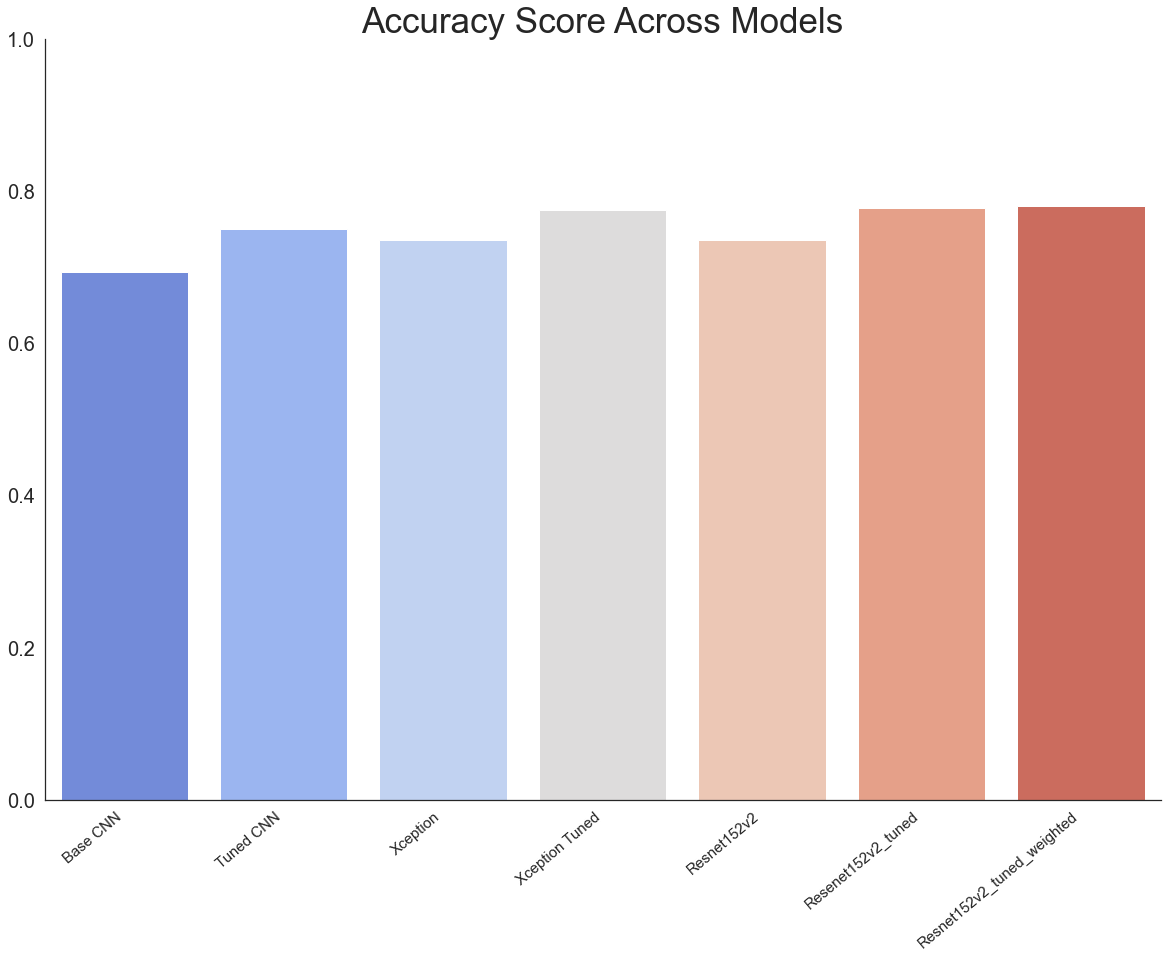

In [21]:
sns.set(style='white')
fig, ax = plt.subplots(figsize=(20, 14))
x_label = x_label2_updated

ax = sns.barplot(x_label, x_updated, palette="coolwarm")
ax.set(ylim=(0, 1))
plt.xticks(rotation=40, size=15, horizontalalignment='right')
plt.yticks(size=20)
sns.despine()

#ax.bar_label(ax.containers[0], padding = 1)

ax.set_title('Accuracy Score Across Models', fontsize=35)
# ax.set_xlabel('Model Number', fontsize=35)

plt.savefig('Skylar_model', bbox_inches='tight');